In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import warnings

In [2]:
# SETUP, hier wird alles vorbereitet
warnings.filterwarnings('ignore')

housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)
print(housing_data.keys())


# Bereinigung und Feature Engeneering

# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]

# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]

# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

# Alle Zustände werden von 1...X auf 0....X-1 geschoben
housing_data["HeizungsqualitaetN"] = [ x-1 for x in housing_data["Heizungsqualitaet"]]
housing_data["ZustandN"] = [ x-1 for x in housing_data["Zustandf"]]
housing_data["FassadeN"] = [ x-1 for x in housing_data["Zustand Fassade"]]
housing_data["KuecheN"] = [ x-1 for x in housing_data["Kuechenqualitaet"]]

# NA in Garage Typ wird zu "Keine Garage"
housing_data["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data["Garage Typ"]]


Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis'],
      dtype='object')


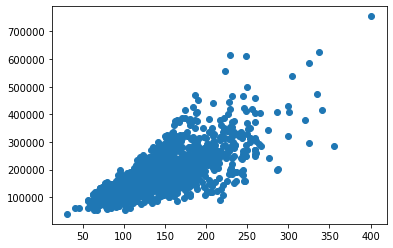

In [3]:
plt.scatter(housing_data["Wohnflaeche in qm"],housing_data["Preis"]) 
# Hierfür Lineare Regression!

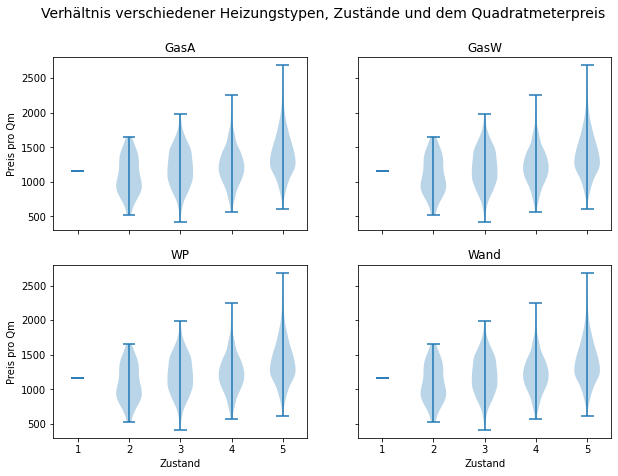

Text(0, 0.5, 'PreisproQm')

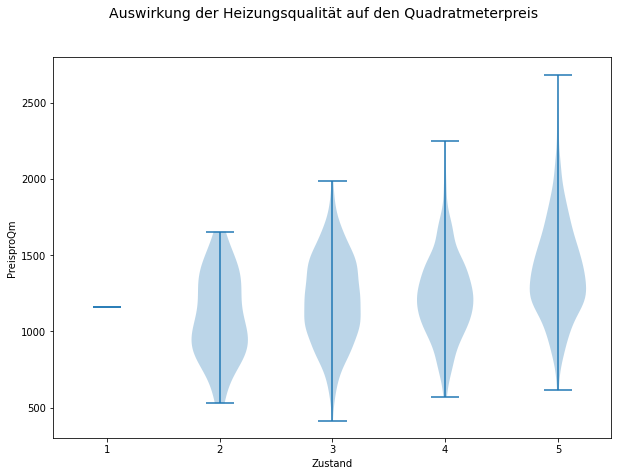

In [53]:
# Florian:
# Heizung, Heizungsqualitaet, Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm, Schlafzimmer, Kuechen, 
#    Kuechenqualität, Räume, Garage Typ, Garagenkapazitt, Verkaufsmonat, Verkaufsjahr, Preis
# untersuchen

# Heizung + Qualitaet
heater_types = housing_data["Heizung"].unique()
heater_quality = np.sort(housing_data["Heizungsqualitaet"].unique())
heater_data = [None]*(len(heater_types)+1)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))
fig.suptitle("Verhältnis verschiedener Heizungstypen, Zustände und dem Quadratmeterpreis", fontsize=14)

for i in range(len(heater_types)):
    for l in range(len(heater_quality)):
        heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
    
    axs[int(i/2),i%2].violinplot(heater_data)
    axs[int(i/2),i%2].set_title(heater_types[i])
    if i > 1:
        axs[int(i/2),i%2].set_xlabel("Zustand")
    if i%2 == 0:
        axs[int(i/2),i%2].set_ylabel("Preis pro Qm")
plt.show()   
# wie man sehen kann, gibt es nur für die Klimaanlage genügend Werte
# Auch hat die Qualität der Heizung nur bei Klimaanlagen annähernd einen Einfluss

plt.figure(figsize=(10,7))
for l in range(len(heater_quality)):
    heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
plt.violinplot(heater_data, heater_quality)
plt.suptitle("Auswirkung der Heizungsqualität auf den Quadratmeterpreis",fontsize=14)
plt.xlabel("Zustand")
plt.ylabel("PreisproQm")
# Auch der Überblick nur über die Heizungsqualitaet hat keinen großen Einfluss auf den €/m²

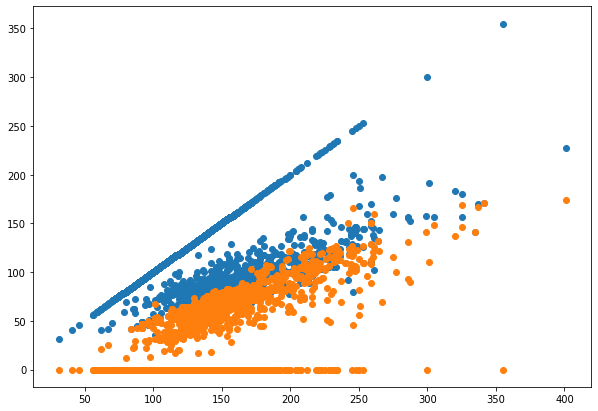

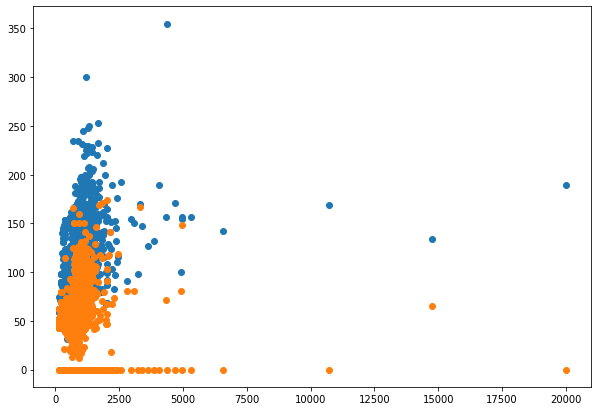

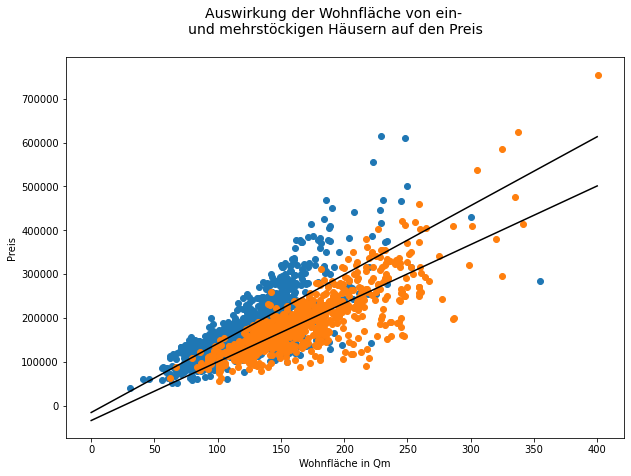

In [66]:
# Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm
# Daten für uns unwichtig, es wird nur kurz darüber geschaut, ob Anomalien und interessante Sachen auftreten
plt.figure(figsize=(10,7))


plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Erster Stock in qm"])
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Zweiter Stock in qm"])
plt.show()
# Wie zu erwarten sieht man nicht viel, es gibt sehr viele einstöckige Häuser

plt.figure(figsize=(10,7))
plt.scatter(housing_data["Grundstueck in qm"], housing_data["Erster Stock in qm"])
plt.scatter(housing_data["Grundstueck in qm"], housing_data["Zweiter Stock in qm"])
plt.show()

one_floor = housing_data[housing_data["Zweiter Stock in qm"] == 0 ]
two_floors = housing_data[housing_data["Zweiter Stock in qm"] != 0 ]


coef = np.polyfit(one_floor["Wohnflaeche in qm"],one_floor["Preis"],1)
poly1d_fn = np.poly1d(coef) 

coef1 = np.polyfit(two_floors["Wohnflaeche in qm"],two_floors["Preis"],1)
poly1d_fn1 = np.poly1d(coef1) 
x = np.linspace(0, 400, 10)

plt.figure(figsize=(10,7))
plt.scatter(one_floor["Wohnflaeche in qm"],one_floor["Preis"])
plt.scatter(two_floors["Wohnflaeche in qm"],two_floors["Preis"])
plt.plot(x, poly1d_fn(x), c="black")
plt.plot(x, poly1d_fn1(x), c="black")

plt.suptitle("Auswirkung der Wohnfläche von ein- \nund mehrstöckigen Häusern auf den Preis",fontsize=14)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis")

plt.show()



# Wohnungen mit mehreren Stockwerken sind bei gleicher Wohnfläche durchweg billiger

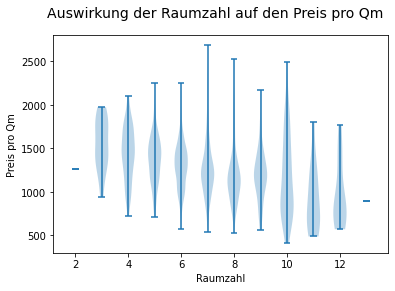

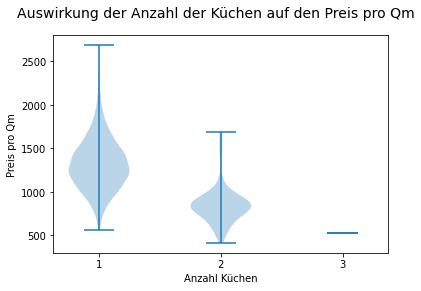

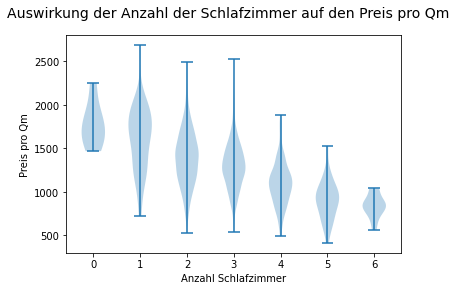

In [72]:
# Schlafzimmer, Kuechen, Räume

# idee: je mehr Räume im Vergleich zu Wohnfläche -> billiger

rooms = np.sort(housing_data["Raeume"].unique())
room_data = [None]*len(rooms)
for i in range(len(rooms)):
    room_data[i] = housing_data[housing_data["Raeume"] == rooms[i]]["Preisproqm"]


plt.violinplot(room_data, rooms)
plt.suptitle("Auswirkung der Raumzahl auf den Preis pro Qm",fontsize=14)
plt.xlabel("Raumzahl")
plt.ylabel("Preis pro Qm")
plt.show()
# ideale Raumzahl liegt bei 7/8 Raeumen

kitchens = np.sort(housing_data["Kuechen"].unique())
kitchen_data = [None]*len(kitchens)
for i in range(len(kitchens)):
    kitchen_data[i] = housing_data[housing_data["Kuechen"] == kitchens[i]]["Preisproqm"]

plt.violinplot(kitchen_data, kitchens)
plt.suptitle("Auswirkung der Anzahl der Küchen auf den Preis pro Qm",fontsize=14)
plt.xlabel("Anzahl Küchen")
plt.xticks([1,2,3])
plt.ylabel("Preis pro Qm")
plt.show()
# Die Anzahl der Kuechen haben wohl keinen Einfluss, oder 1 Kueche > 2?


bedrooms = np.sort(housing_data["Schlafzimmer"].unique())
bedroom_data = [None]*len(bedrooms)
for i in range(len(bedrooms)):
    bedroom_data[i] = housing_data[housing_data["Schlafzimmer"] == bedrooms[i]]["Preisproqm"]

plt.violinplot(bedroom_data, bedrooms)
plt.suptitle("Auswirkung der Anzahl der Schlafzimmer auf den Preis pro Qm",fontsize=14)
plt.xlabel("Anzahl Schlafzimmer")
plt.ylabel("Preis pro Qm")
plt.show()
# Die Anzahl der Schlafzimmer ist komisch, 1 Schlafzimmer ist am beliebtesten? Vllt sind sehr kleine Wohnflächen 
#    teurerer als im Vergleich?

# TODO: Anzahl Raum vs Wohnfläche -> Raumgröße?
# Raumgröße vs. Preis??

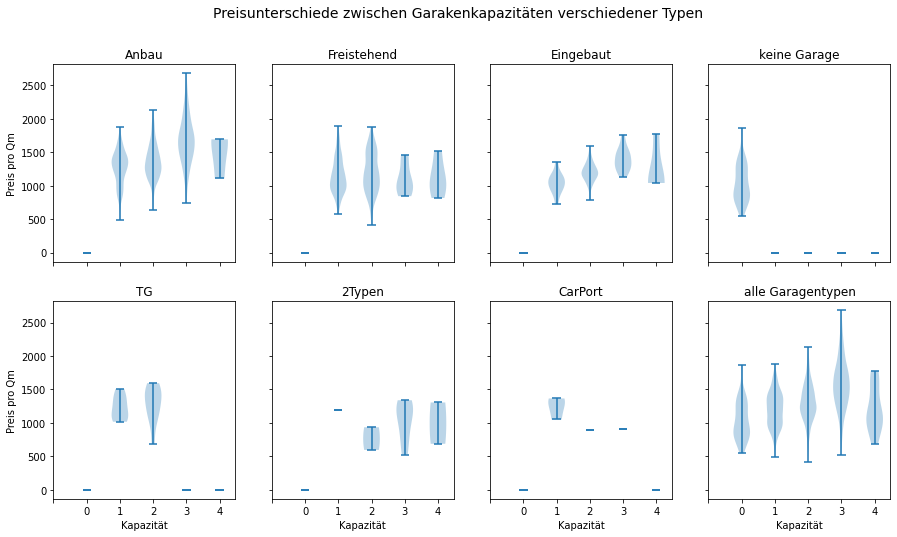

In [157]:
#Garage Typ, Garagenkapazität
# wahrscheinlich -> mehr Garagen -> teurer?

garage_types = housing_data["Garage Typ"].unique()


fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15,8))

for i in range(len(garage_types)):
    type_data = housing_data[housing_data["Garage Typ"] == garage_types[i]]
    garage_capacity = [0,1,2,3,4] #np.sort(type_data["Garagenkapazitaet"].unique())
    garage_data = [0]*(len(garage_capacity))
    
    for l in garage_capacity:
        garage_data[l] = type_data[housing_data["Garagenkapazitaet"] == l]["Preisproqm"].values.tolist()
        if garage_data[l] == []:
            garage_data[l] = [0]
            # Ich habe keine bessere Umsetzung gefunden, Recherche hat auch nicht weitergeholfen
            # jetzt ist überall mindestens ein Dummywert [0] drinnen -.-
            # das ist sogar richtig
            
    axs[int(i/4),i%4].violinplot(garage_data)
    axs[int(i/4),i%4].set_title(garage_types[i])
    
    
    
# Anbaugaragen sind mitunter am teuersten, wobei die anderen im €/qm Bereich sind, wie, wenn keine Garage vorhanden ist
# Der Einfluss von Garagen auf den Preis ist nicht signifikant

garage_capacity = np.sort(housing_data["Garagenkapazitaet"].unique())
garage_data = [0]*(len(garage_capacity))
for i in range(len(garage_capacity)):
    garage_data[i] = housing_data[housing_data["Garagenkapazitaet"] == garage_capacity[i]]["Preisproqm"]


axs[1,3].violinplot(garage_data)
axs[1,3].set_title("alle Garagentypen")
fig.suptitle("Preisunterschiede zwischen Garakenkapazitäten verschiedener Typen", fontsize=14)

for i in range(8):
    plt.sca(axs[int(i/4),i%4])
    plt.xticks(range(6), ["","0","1","2","3","4"])
    if i > 3:
        plt.xlabel("Kapazität")
    if i % 4 == 0:
        plt.ylabel("Preis pro Qm")

    #das funktioniert, aber wieso?? wieso ["","0",..?
plt.show()
# Auch der Überblick nur über die Garagenkapazitaet hat keinen großen Einfluss auf den €/m²


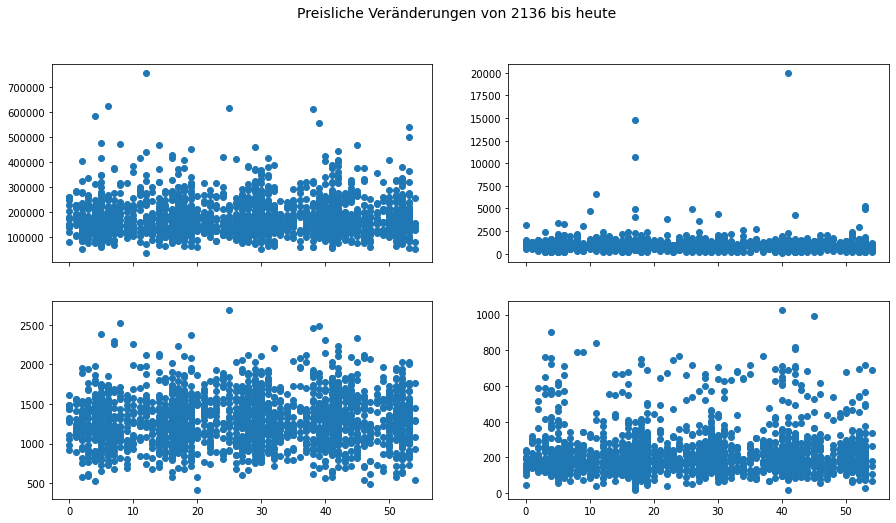

In [162]:
# Verkaufsmonat, Verkaufsjahr, Preis
# Verkaufsmonat sollte weniger einfluss auf den Preis haben
# Verkaufsjahr sollte einen Anstieg wegen der Erhöhung der Mietpreise aufzeigen

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15,8))

axs[0,0].scatter(housing_data["Monate"],housing_data["Preis"])
axs[0,1].scatter(housing_data["Monate"],housing_data["Grundstueck in qm"])
axs[1,0].scatter(housing_data["Monate"],housing_data["Preisproqm"])
axs[1,1].scatter(housing_data["Monate"],housing_data["Preis"]/housing_data["Grundstueck in qm"])

fig.suptitle("Preisliche Veränderungen von 2136 bis heute",fontsize=14)

plt.show()
# es gibt fast keinen Anstieg zwischen den Jahren
# Es werden teurere Wohnungen in den Sommermonaten verkauft, auch deutlich mehr
# TODO in 2x2 Matrix!
# Lin reg für Entwicklung von Preis!

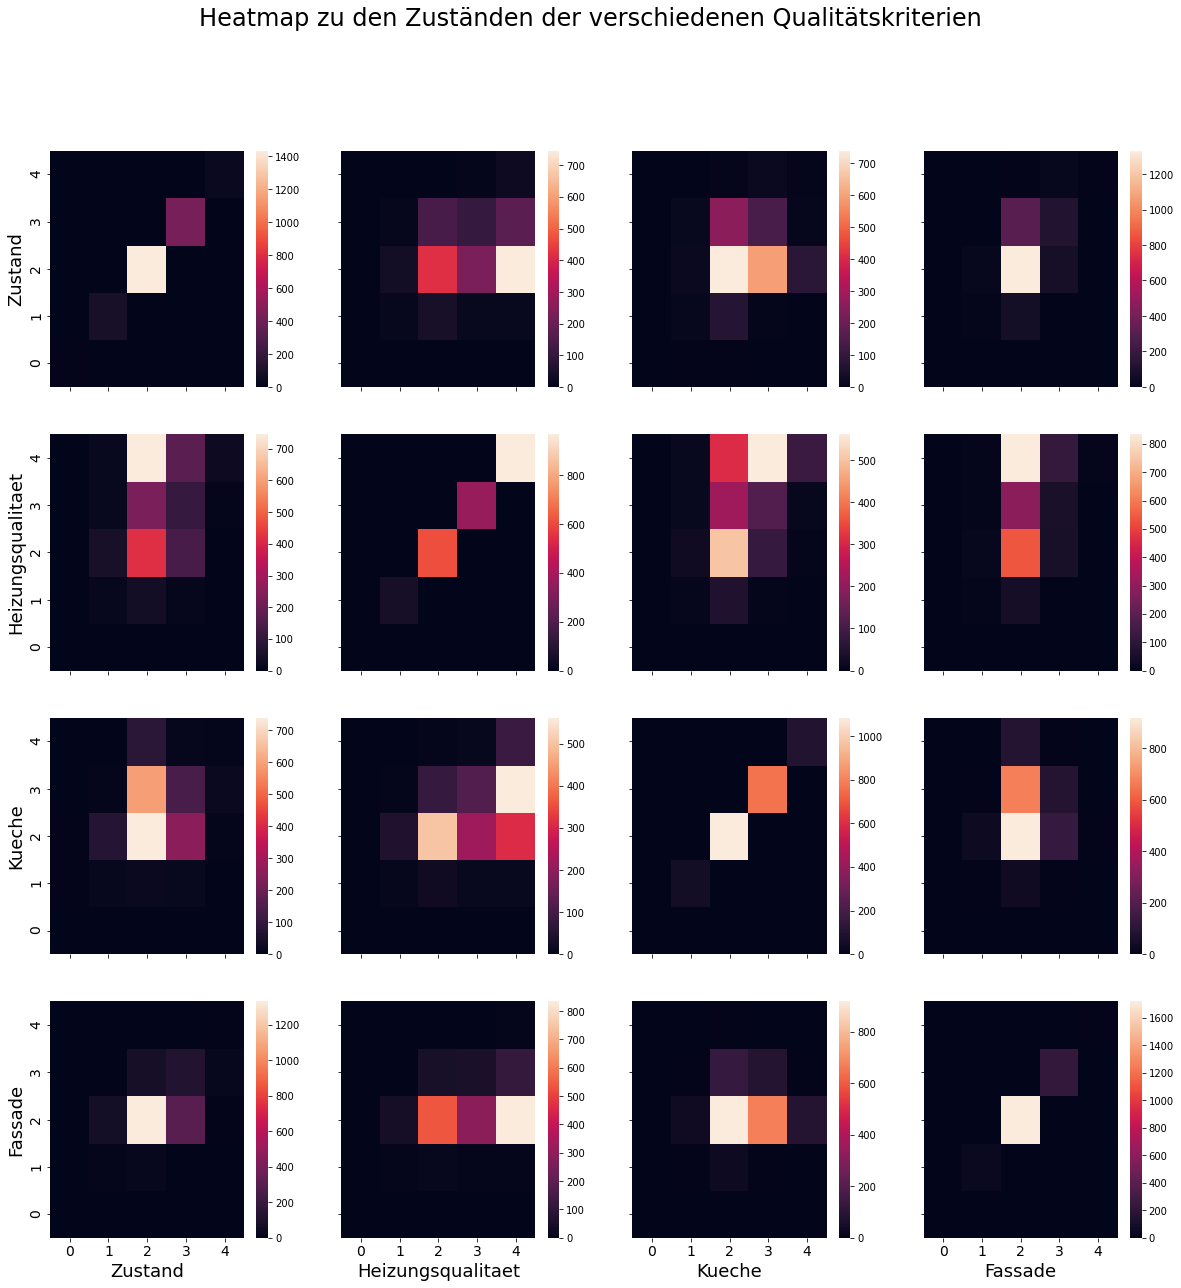

In [176]:
# Heizungsqualitaet, Kuechnqualitaet, Fassadenqualitaet und Zustand 
# (Zustandf, damit ein Vergleich einfacher moeglich ist)

# Daten vorbereiten für heatmap: im Besten Fall sollte eine Diagonale von Links unten -> rechts oben gehen
# Achtung Rechenintensiv!
keys = ["ZustandN", "HeizungsqualitaetN", "KuecheN", "FassadeN"]


fig, axs = plt.subplots(len(keys), len(keys), sharex=True, sharey=True, figsize=(20,20))
fig.suptitle("Heatmap zu den Zuständen der verschiedenen Qualitätskriterien",fontsize=24)
# Zweimal über Keys iterieren -> key1 X key2 Plots (key1 == key2)
# für jeden Plot alle Möglichen Werte von key1 heraussuchen -> X-Achse
# für jeden möglichen X-Wert alle Y-Werte von key2 in data schreiben
# happy plotting
for i in range(len(keys)):
    values = [0,1,2,3,4]
    for l in range(len(keys)):
        
        data = [None]*len(values)
        for f in range(len(values)):
            data[f] = [0]*len(values)
        data[1][1] = 2
        for value in values:
            raw_data = housing_data[housing_data[keys[i]] == value][keys[l]]
            unique, counts = np.unique(raw_data, return_counts=True)
            count = dict(zip(unique, counts))
            for key in count.keys():
                # Es tut mir ja leid
                data[value][key] = count[key]
        sb.heatmap(data, ax = axs[i,l]) #vmin=0, vmax=16000, center=8000
        axs[i,l].invert_yaxis()
        plt.sca(axs[i,l])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # Hm, vllt gibts da auch nen besseren Weg
        if i == len(keys)-1:
            axs[i,l].set_xlabel(str(keys[l][:-1]), fontsize=18)
        if l == 0:
            axs[i,l].set_ylabel(str(keys[i][:-1]), fontsize=18)
    
# Es existieren nur relativ wenige wirklich Schlechte Zustände, auch stehen sie nur wenig in Korrelation
# im oberen x- und y- Bereich gibt es Bessere Korrelationen, so sind in einem Bereich positiv (2+) bewertete
# auch in den anderen Bereichen positiv. Die charakteristischen Diagonalen, wie man sie bei starken Korrelationen
# sieht, sind aber hier nicht wirklich vorhanden


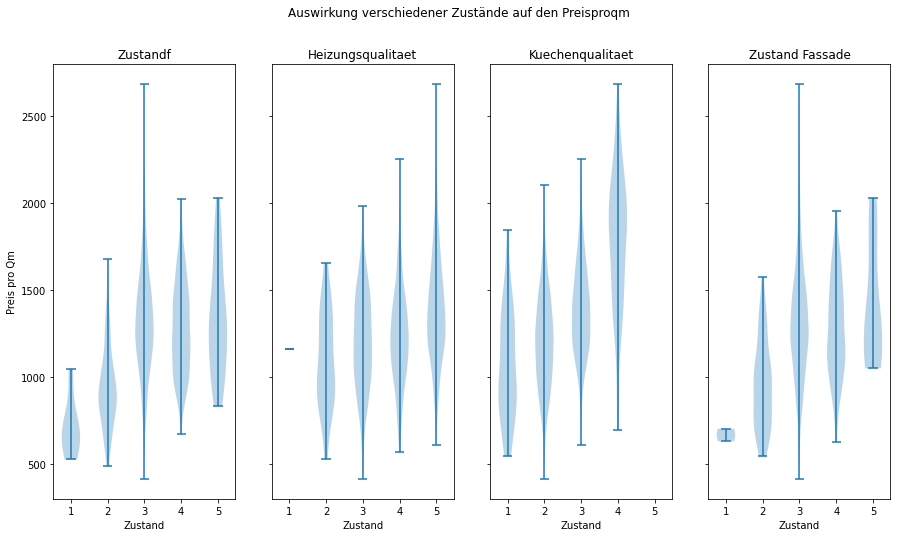

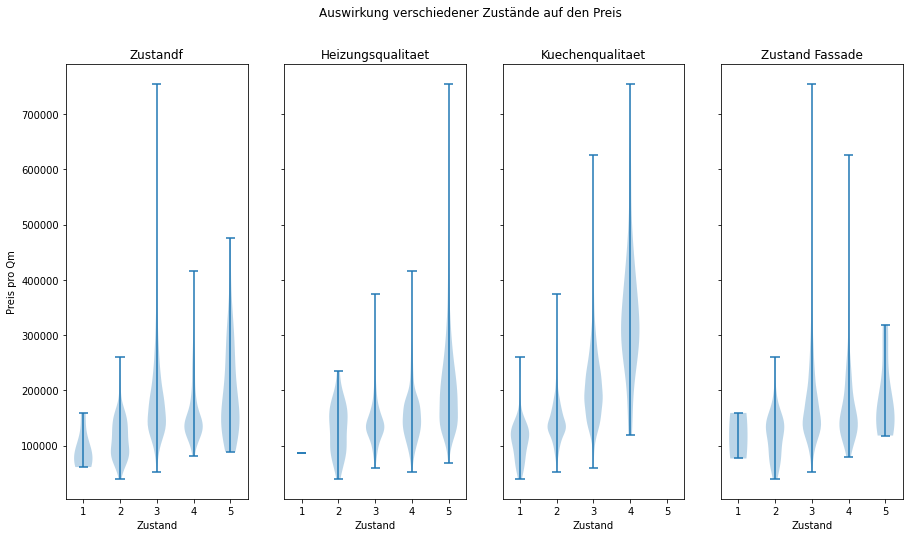

In [185]:
keys = ["Zustandf", "Heizungsqualitaet", "Kuechenqualitaet", "Zustand Fassade"]
rows = ["Preisproqm", "Preis"]

for f in range(len(rows)):
    fig, axs = plt.subplots(1, len(keys), sharex=True, sharey=True, figsize=(15,8))
    for x in range(len(keys)):
        quality = np.sort(housing_data[keys[x]].unique())
        data = [None]*len(quality)
        for i in range(len(quality)):
            data[i] = housing_data[housing_data[keys[x]] == quality[i]][rows[f]]
        axs[x].violinplot(data)
        axs[x].set_title(str(keys[x]))
        axs[x].set_xticks([1,2,3,4,5])
        axs[x].set_xlabel("Zustand")
        if x == 0:
            axs[x].set_ylabel("Preis pro Qm")
    
    fig.suptitle("Auswirkung verschiedener Zustände auf den " + rows[f])
    plt.show()
    
    
    # Man kann einige preisliche Anstiege sehen, besonders bei der Kuechenqualität vs Preis
    # da ist wohl nur das Problem, dass der rest der Wohnung wohl auch luxurioeser wird und 
    # das für die Arbeit NICHT gewollt ist, ( es soll Geld mit einzelnen, wenn auch mehreren Renovationen gemacht werden
    # nicht mit einem Umbau in ein neues Haus!)
    # hier sehen wir mehrere Ausreisser bei dem Verkaufspreis, diese sind aber für die weitere Arbeit nicht sehr wichtig, 
    # da es genug weitere Datenpunkte gibt.

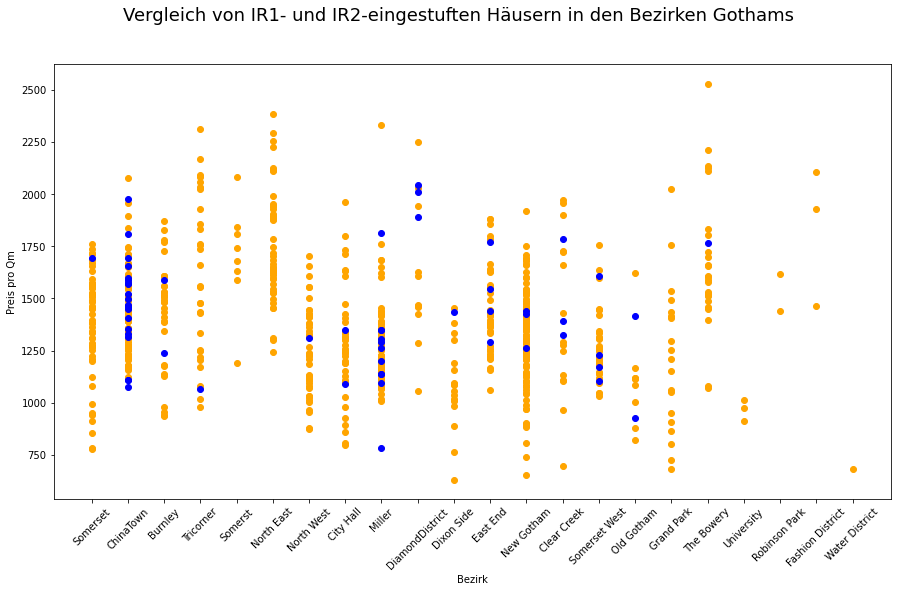

In [201]:
#Grundstücksform

house_reg = housing_data[housing_data.Grundstuecksform == "Reg"]
house_ir1 = housing_data[housing_data.Grundstuecksform == "IR1"]
house_ir2 = housing_data[housing_data.Grundstuecksform == "IR2"]
house_ir3 = housing_data[housing_data.Grundstuecksform == "IR3"]

plt.figure(figsize=(15,8))
plt.scatter(house_ir1["Bezirk"],house_ir1["Preis"]/house_ir1["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir2["Bezirk"],house_ir2["Preis"]/house_ir2["Wohnflaeche in qm"], c="blue")


plt.suptitle("Vergleich von IR1- und IR2-eingestuften Häusern in den Bezirken Gothams",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.show()

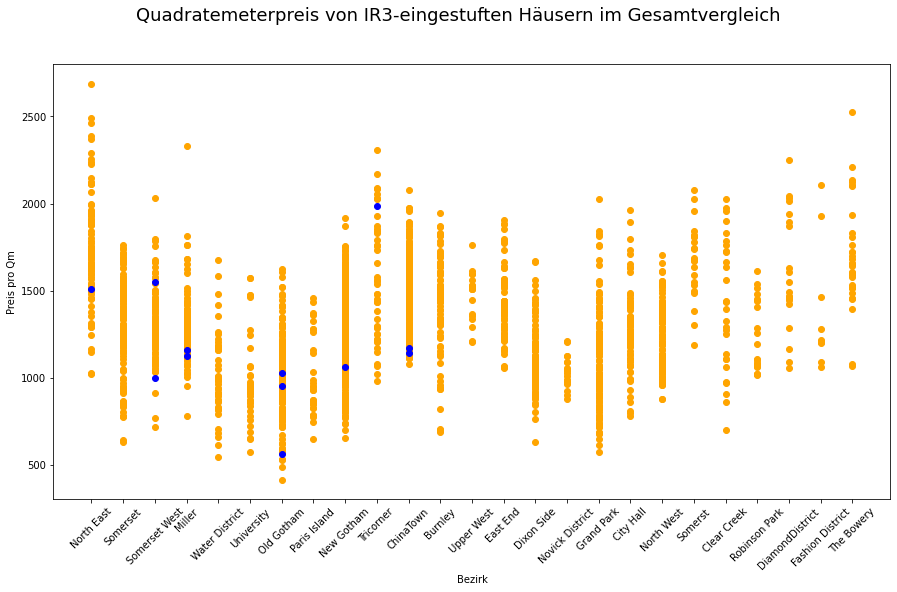

In [204]:
plt.figure(figsize=(15,8))
plt.scatter(house_reg["Bezirk"],house_reg["Preis"]/house_reg["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir1["Bezirk"],house_ir1["Preis"]/house_ir1["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir2["Bezirk"],house_ir2["Preis"]/house_ir2["Wohnflaeche in qm"], c="orange")
plt.scatter(house_ir3["Bezirk"],house_ir3["Preis"]/house_ir3["Wohnflaeche in qm"], c="blue")


plt.suptitle("Quadratemeterpreis von IR3-eingestuften Häusern im Gesamtvergleich",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.show()
#Bei der Grundstücksform lässt sich absehen, dass Häuser der Form IR1 meist teurer sind als diese der Form IR2. 
#Bei Häusern der Form IR3 handelt es sich meist um billigere Häuser, als bei den anderen Grundstücksformen.

In [ ]:
# Steigung

house_evelation = housing_data[housing_data.Steigung == "Ja"]
house_no_evelation = housing_data[housing_data.Steigung == "Nein"]

plt.figure(figsize=(30,10))
plt.scatter(house_evelation["Bezirk"],house_evelation["Preis"]/house_evelation["Wohnflaeche in qm"], c="blue")
plt.scatter(house_no_evelation["Bezirk"],house_no_evelation["Preis"]/house_no_evelation["Wohnflaeche in qm"], c="orange")

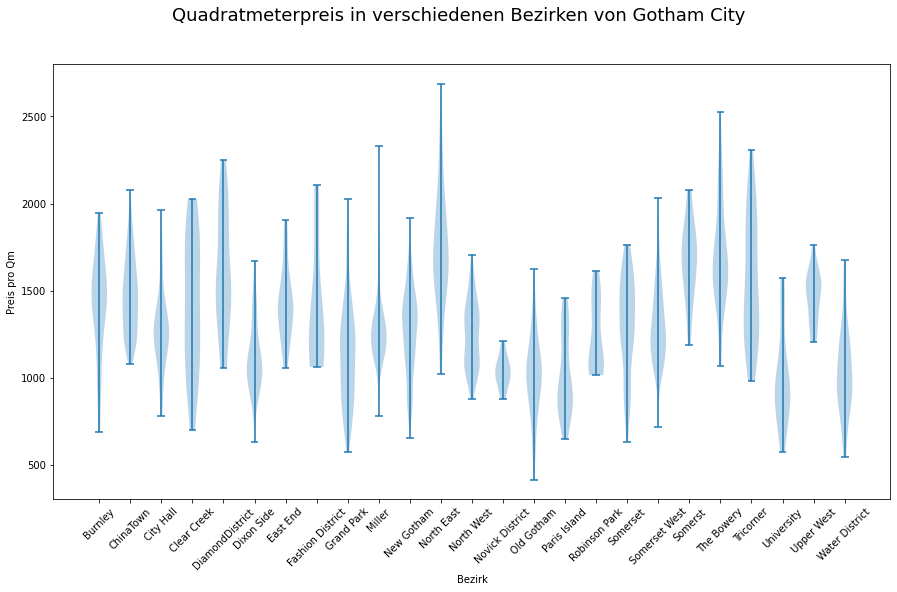

In [209]:
#Bezirke

key = "Bezirk"
rows = ["Preisproqm"]
quality = np.sort(housing_data[key].unique())

for row in rows:
    fig= plt.figure(figsize=(15,8))
    data = [None]*len(quality)
    for i in range(len(quality)):
        data[i] = housing_data[housing_data[key] == quality[i]][row]

    plt.violinplot(data)
    plt.suptitle("Quadratmeterpreis in verschiedenen Bezirken von Gotham City",fontsize=18)
    plt.xlabel("Bezirk")
    plt.ylabel("Preis pro Qm")
    plt.xticks(np.arange(len(quality)) + 1, quality, rotation=45)
    
    plt.show()


#Je nachdem, in welchem Bezirk eine Immobilie liegt, ändert sich ihr Wert.

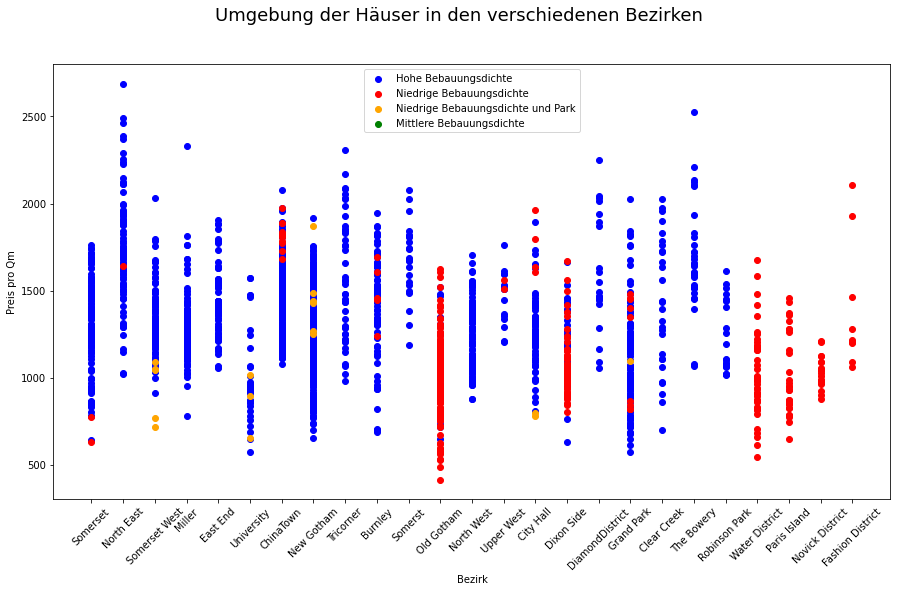

In [214]:
#Zone

house_rh = housing_data[housing_data.Zone == "RH"]
house_rl = housing_data[housing_data.Zone == "RL"]
house_rp = housing_data[housing_data.Zone == "RP"]
house_rm = housing_data[housing_data.Zone == "RM"]

plt.figure(figsize=(15,8))
plt.scatter(house_rl["Bezirk"],house_rl["Preis"]/house_rl["Wohnflaeche in qm"], c="blue")
plt.scatter(house_rm["Bezirk"],house_rm["Preis"]/house_rm["Wohnflaeche in qm"], c="red")
plt.scatter(house_rh["Bezirk"],house_rh["Preis"]/house_rh["Wohnflaeche in qm"], c="orange")
plt.scatter(house_rp["Bezirk"],house_rp["Preis"]/house_rp["Wohnflaeche in qm"], c="green")



plt.suptitle("Umgebung der Häuser in den verschiedenen Bezirken",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Hohe Bebauungsdichte", "Niedrige Bebauungsdichte",
            "Niedrige Bebauungsdichte und Park","Mittlere Bebauungsdichte"])
plt.show()
#In Gotham gibt es kaum Immobilien, welche sich in einer hohen Bebauungsdichte befinden und keine, 
#    welche sich in einer niedrigen Bebauungsdichte und bei einem Park befinden. 
#In den Bezirken Miller, East End, Tricorner, Somerst, North West, Diamond District, Clear Creek, The Bowery und
#    Robinson Park stehen Häuser nur in einer geringen Bebauungsdichte.
#Dagegen gibt es in den Bezirken Water District, Paris Island, Novick Distric und 
#    Fashion Districtnur Häuser in mittlerer Bebauungsdichte.
#Und  Häuser in hoher Bebauungsdichte gibt es kaum. 
#Gotham ist keine Stadt, die stark bebaut ist. 

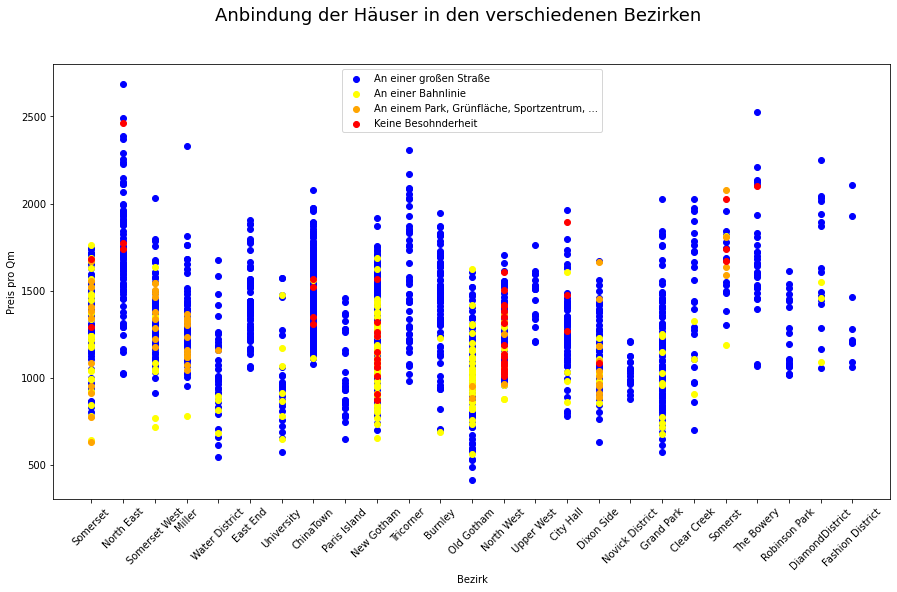

In [216]:
#Lage

house_straße = housing_data[housing_data.Lage == "Str"]
house_bahn = housing_data[housing_data.Lage == "Bahn"]
house_park = housing_data[housing_data.Lage == "Pos"]
house_normal = housing_data[housing_data.Lage == "Norm"]

plt.figure(figsize=(15,8))
plt.scatter(house_normal["Bezirk"],house_normal["Preis"]/house_normal["Wohnflaeche in qm"], c="blue")
plt.scatter(house_straße["Bezirk"],house_straße["Preis"]/house_straße["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_bahn["Bezirk"],house_bahn["Preis"]/house_bahn["Wohnflaeche in qm"], c="orange")
plt.scatter(house_park["Bezirk"],house_park["Preis"]/house_park["Wohnflaeche in qm"], c="red")

plt.suptitle("Anbindung der Häuser in den verschiedenen Bezirken",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["An einer großen Straße", "An einer Bahnlinie",
            "An einem Park, Grünfläche, Sportzentrum, ...","Keine Besonderheit"])
plt.show()



#Mit Außnahme von Old Gotham lässt sich sagen, dass Häuser in der Nähe von Bahnlinien und 
#    Parks teurer sind, als Häuser nahe einer großen Straße.
#Des weiteren gibt es in den Bezirken East End, Paris Island, Tricorner, Upper West, 
#    Novick District Robinson Park, Fashion District keine Häuser, die sich in der Nähe von 
#    Bahnlinien, großen Straßen oder Parks befinden.

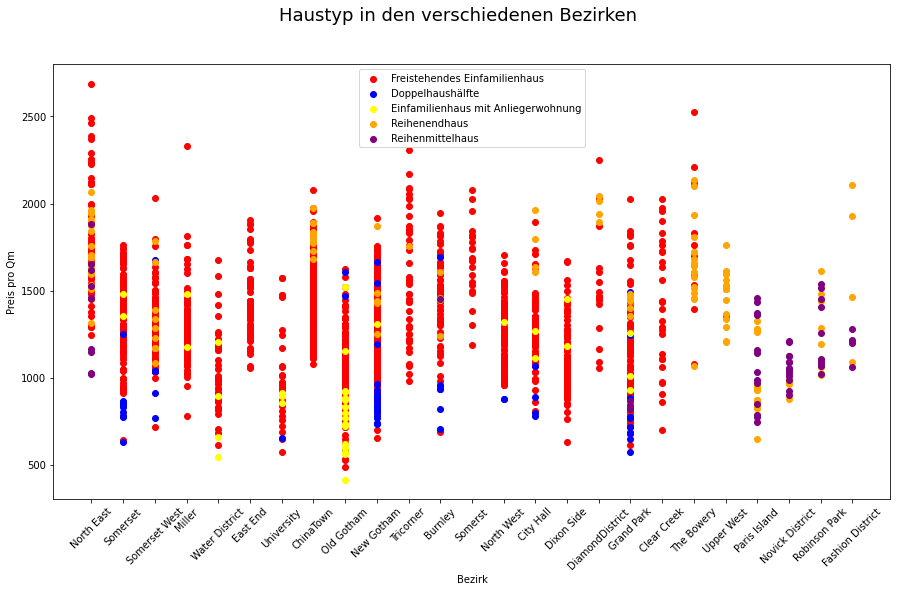

Reihenhäuser ['Y'] ['Y']


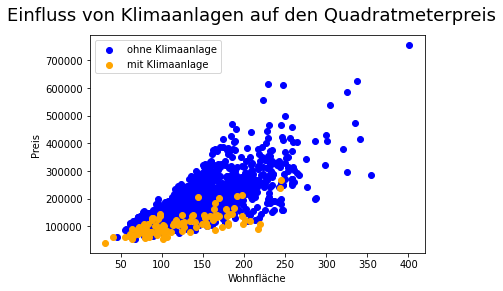

In [219]:
#Haustyp + #Klimaanlage

house_1fam = housing_data[housing_data.Typ == "1Fam"]
house_2fam = housing_data[housing_data.Typ == "2Fam"]
house_2faman = housing_data[housing_data.Typ == "2FamAn"]
house_reh = housing_data[housing_data.Typ == "REH"]
house_rmh = housing_data[housing_data.Typ == "RMH"]

plt.figure(figsize=(15,8))
plt.scatter(house_1fam["Bezirk"],house_1fam["Preis"]/house_1fam["Wohnflaeche in qm"], c="red")
plt.scatter(house_2fam["Bezirk"],house_2fam["Preis"]/house_2fam["Wohnflaeche in qm"], c="blue")
plt.scatter(house_2faman["Bezirk"],house_2faman["Preis"]/house_2faman["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_reh["Bezirk"],house_reh["Preis"]/house_reh["Wohnflaeche in qm"], c="orange")
plt.scatter(house_rmh["Bezirk"],house_rmh["Preis"]/house_rmh["Wohnflaeche in qm"], c="purple")

plt.suptitle("Haustyp in den verschiedenen Bezirken",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Freistehendes Einfamilienhaus", "Doppelhaushälfte",
            "Einfamilienhaus mit Anliegerwohnung","Reihenendhaus","Reihenmittelhaus"])

plt.show()

print("Reihenhäuser", house_rmh["Klimaanlage"].unique(), house_reh["Klimaanlage"].unique())

house_ac = housing_data[housing_data.Klimaanlage == "Y"]
house_not_ac = housing_data[housing_data.Klimaanlage == "N"]
plt.scatter(house_ac["Wohnflaeche in qm"],house_ac["Preis"], c='blue')
plt.scatter(house_not_ac["Wohnflaeche in qm"],house_not_ac["Preis"],c="orange")

plt.suptitle("Einfluss von Klimaanlagen auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Wohnfläche")
plt.ylabel("Preis")
plt.legend(["ohne Klimaanlage", "mit Klimaanlage"])

#Klimaanlagen steigern den Wert einer Immobilie.

#In Gothem gibt es nur wenige 2-Familien-Anbau Häuser. 
#Die Bezirke Clear Creek & East End bestehen sogar einzig aus 1-Familien Häusern.
#Im Gegenzug gibt es in den Bezirken Paris Island, Novick District, Robinson Park und 
#    Fashion District nur Reihenhäuser. Upper West konkreter besitzt bloß  Reihenendhäuser mit 
#    Außnahme eines einzigen ein 1-Familien Hauses.
#Zu Reihenhäusern ist noch zu sagen, dass diese nur mit Klimaanlage kommen.
#Klimaanlagen steigern den Immobilienpreis.

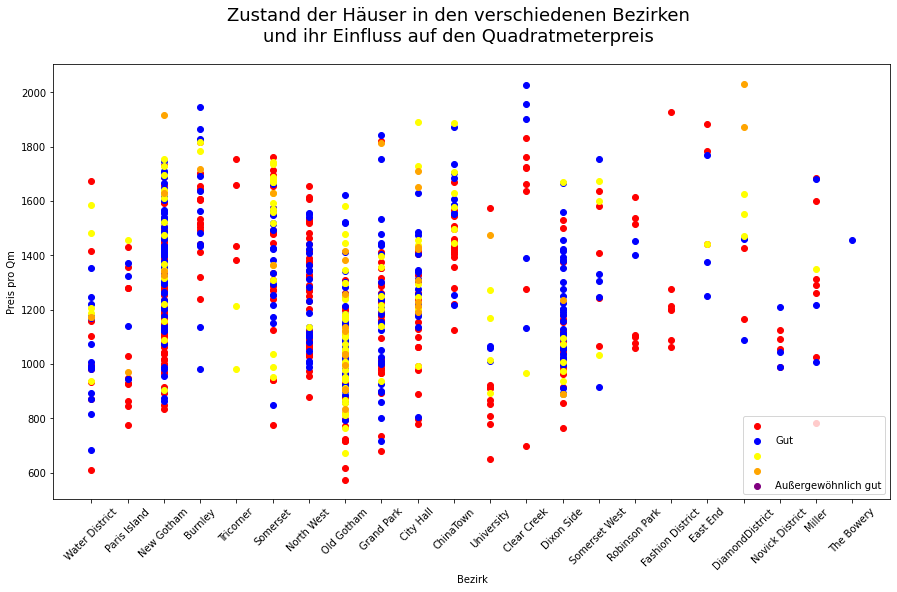

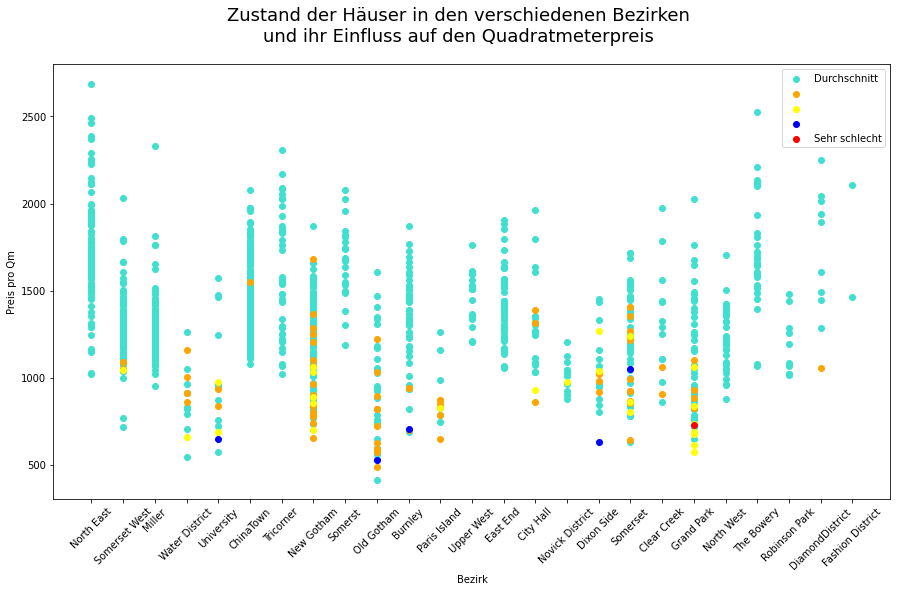

In [222]:
#Zustand

house_1 = housing_data[housing_data.Zustand == 1]
house_2 = housing_data[housing_data.Zustand == 2]
house_3 = housing_data[housing_data.Zustand == 3]
house_4 = housing_data[housing_data.Zustand == 4]
house_5 = housing_data[housing_data.Zustand == 5]
house_6 = housing_data[housing_data.Zustand == 6]
house_7 = housing_data[housing_data.Zustand == 7]
house_8 = housing_data[housing_data.Zustand == 8]
house_9 = housing_data[housing_data.Zustand == 9]
house_10 = housing_data[housing_data.Zustand == 10]

fig= plt.figure(figsize=(15,8))
plt.scatter(house_6["Bezirk"],house_6["Preis"]/house_6["Wohnflaeche in qm"], c="red")
plt.scatter(house_7["Bezirk"],house_7["Preis"]/house_7["Wohnflaeche in qm"], c="blue")
plt.scatter(house_8["Bezirk"],house_8["Preis"]/house_8["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_9["Bezirk"],house_9["Preis"]/house_9["Wohnflaeche in qm"], c="orange")
plt.scatter(house_10["Bezirk"],house_10["Preis"]/house_10["Wohnflaeche in qm"], c="purple")

plt.suptitle("Zustand der Häuser in den verschiedenen Bezirken\nund ihr Einfluss auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend([" ", "Gut",
            " "," ","Außergewöhnlich gut"])

plt.show()

fig= plt.figure(figsize=(15,8))
plt.scatter(house_5["Bezirk"],house_5["Preis"]/house_5["Wohnflaeche in qm"], c="turquoise")
plt.scatter(house_4["Bezirk"],house_4["Preis"]/house_4["Wohnflaeche in qm"], c="orange")
plt.scatter(house_3["Bezirk"],house_3["Preis"]/house_3["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_2["Bezirk"],house_2["Preis"]/house_2["Wohnflaeche in qm"], c="blue")
plt.scatter(house_1["Bezirk"],house_1["Preis"]/house_1["Wohnflaeche in qm"], c="red")

plt.suptitle("Zustand der Häuser in den verschiedenen Bezirken\nund ihr Einfluss auf den Quadratmeterpreis",fontsize=18)
plt.xlabel("Bezirk")
plt.ylabel("Preis pro Qm")
plt.xticks(rotation=45)
plt.legend(["Durchschnitt", " ",
            " "," ","Sehr schlecht"])
plt.show()
#Ein eine deutliche Abhängigkeit von Immobilienpreis und -zustand lässt sich nur bei den 
#    Zuständen 5 und drunter erkennen.

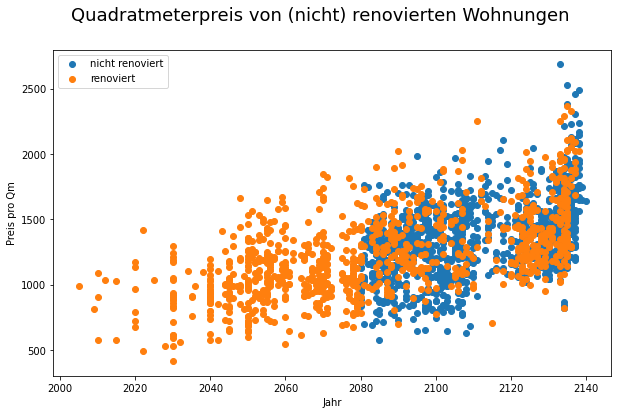

In [225]:
#Gebaut + Renoviert

house_renovated = housing_data[housing_data.Gebaut != housing_data.Renoviert]
house_not_renovated = housing_data[housing_data.Gebaut == housing_data.Renoviert]

fig= plt.figure(figsize=(10,6))

plt.scatter(house_not_renovated["Gebaut"],house_not_renovated["Preis"]/house_not_renovated["Wohnflaeche in qm"])
plt.scatter(house_renovated["Gebaut"],house_renovated["Preis"]/house_renovated["Wohnflaeche in qm"])

plt.suptitle("Quadratmeterpreis von (nicht) renovierten Wohnungen ",fontsize=18)
plt.xlabel("Jahr")
plt.ylabel("Preis pro Qm")
plt.legend(["nicht renoviert", "renoviert"])
plt.show()

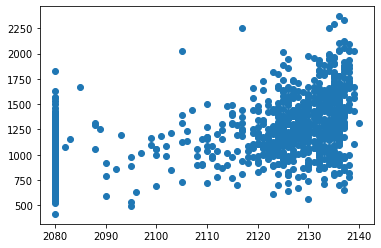

In [20]:
plt.scatter(house_renovated["Renoviert"],house_renovated["Preis"]/house_renovated["Wohnflaeche in qm"])


#Der Preis pro Qaudratmeter ist nur bei renovierten Häusern vom Baujahr/Renovationsjahr abhängig 
#Alle Häuser, die vor 2080 gebaut wurden, wurden renoviert.
#Häuser, die nach dem Jahr 2130 gebaut wurden, können um einiges teurer sein, als die Häuser, die in vorherigen Jahren 
#    gebaut worden sind.
#Preise von renovierten und unrenovierten Häusern unterscheiden sich nicht erkennbar voneinander.
#Im Jahr 2080 wurden viele Häuser renoviert. Die Zahl der Renovierungen sank in den nächsten paar Jahren dramatisch, 
#    wächst aber mit den folgenden Jahren.
#Nach 2110 werden fast keine Hauser günstiger als 100000 GC Dollar gebaut.
#Je später ein Haus gebaut wird, desto teurer ist es. Diese steigung ist jedoch gering. Vermutlich entsteht diese 
#    Steigung Aufgrund von inflation.

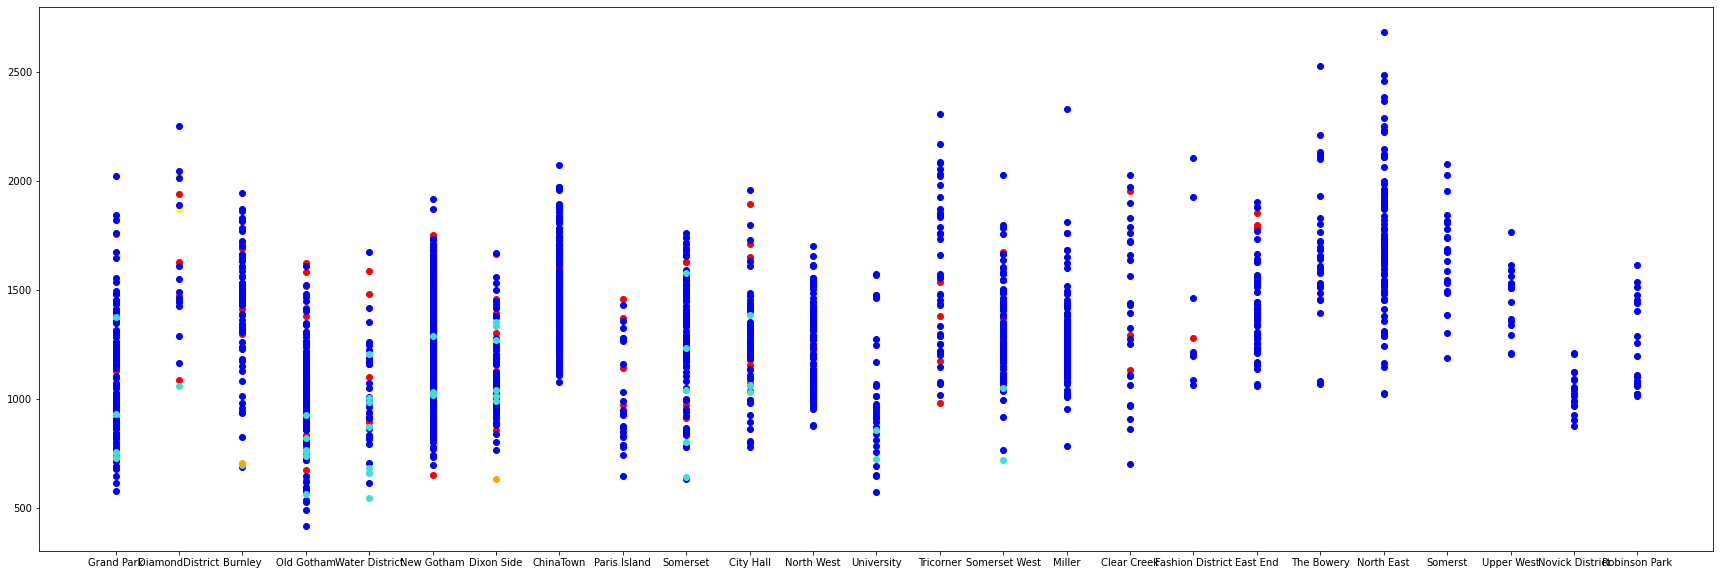

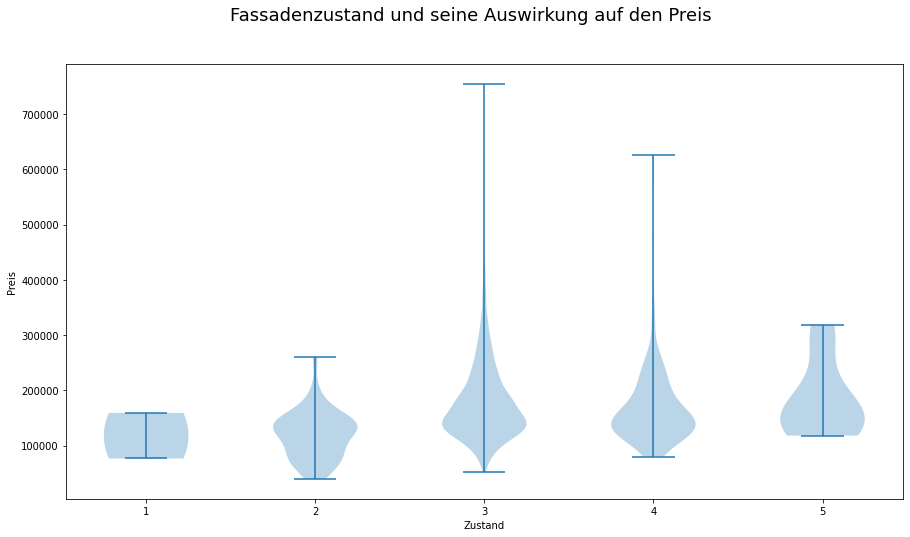

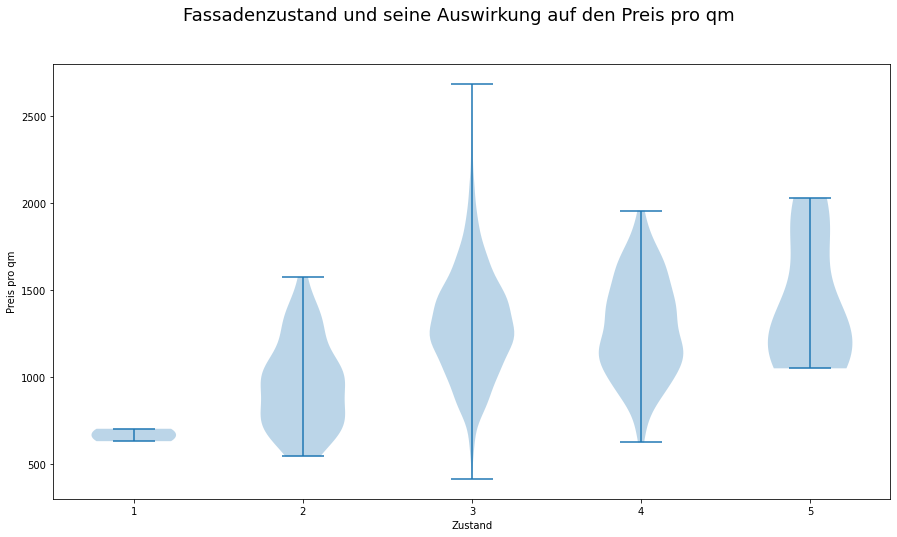

In [229]:
#Zustand Fassade

house_1 = housing_data[housing_data["Zustand Fassade"] == 1]
house_2 = housing_data[housing_data["Zustand Fassade"] == 2]
house_3 = housing_data[housing_data["Zustand Fassade"] == 3]
house_4 = housing_data[housing_data["Zustand Fassade"] == 4]
house_5 = housing_data[housing_data["Zustand Fassade"] == 5]


plt.figure(figsize=(30,10))

plt.scatter(house_5["Bezirk"],house_5["Preis"]/house_5["Wohnflaeche in qm"], c="yellow")
plt.scatter(house_4["Bezirk"],house_4["Preis"]/house_4["Wohnflaeche in qm"], c="red")
plt.scatter(house_3["Bezirk"],house_3["Preis"]/house_3["Wohnflaeche in qm"], c="blue")
plt.scatter(house_2["Bezirk"],house_2["Preis"]/house_2["Wohnflaeche in qm"], c="turquoise")
plt.scatter(house_1["Bezirk"],house_1["Preis"]/house_1["Wohnflaeche in qm"], c="orange")

#Die meisten Fassaden in Gotham befinden sich in einem Zustand von 3 oder 4. 
#Größere preisliche unterschiede lassen sich nur zwischen Zuständen 1 2 und 5 erkennen.

key = "Zustand Fassade"
rows = ["Preis", "Preis pro qm"]
quality = np.sort(housing_data[key].unique())

for row in rows:
    fig= plt.figure(figsize=(15,8))
    data = [None]*len(quality)
    for i in range(len(quality)):
        data[i] = housing_data[housing_data[key] == quality[i]][row.replace(" ","")]

    plt.violinplot(data)
    plt.suptitle("Fassadenzustand und seine Auswirkung auf den " + row,fontsize=18)
    plt.xlabel("Zustand")
    plt.ylabel(row)
    plt.show()

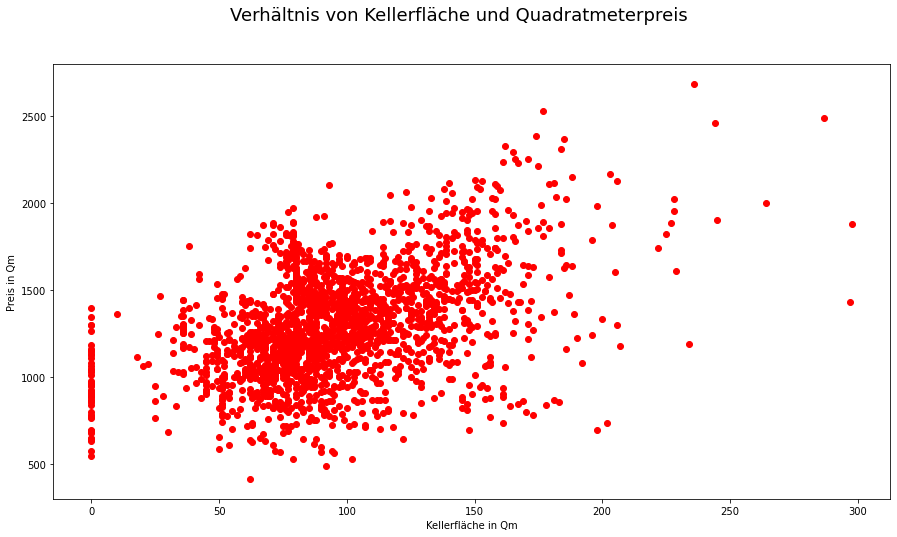

In [231]:
#Kellerfläche
plt.figure(figsize=(15,8))

plt.scatter(housing_data["Kellerflaeche in qm"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"], c="red")

plt.suptitle("Verhältnis von Kellerfläche und Quadratmeterpreis",fontsize=18)
plt.xlabel("Kellerfläche in Qm")
plt.ylabel("Preis in Qm")
plt.show()
#Falls eine Immobilie eine größere Kellerfläche hat, kann sie einen höheren Marktwert erreichen.
#Es ist anzumerken, dass es auch viele Wohnungen ohne Keller gibt.

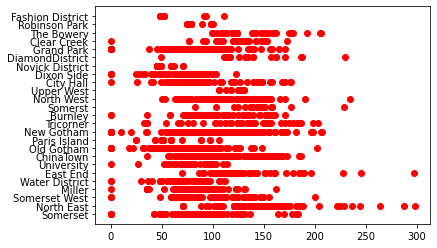

In [23]:
plt.scatter(housing_data["Kellerflaeche in qm"],housing_data["Bezirk"], c="red")

#Nebenbei gibt es in East End und in North East die größten Keller in Gotham.

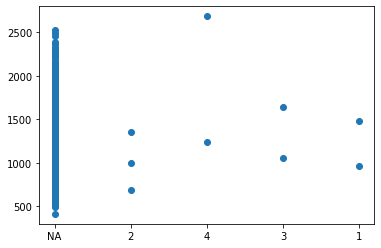

In [24]:
#Pool

plt.scatter(housing_data["Pool"], housing_data["Preis"]/housing_data["Wohnflaeche in qm"])

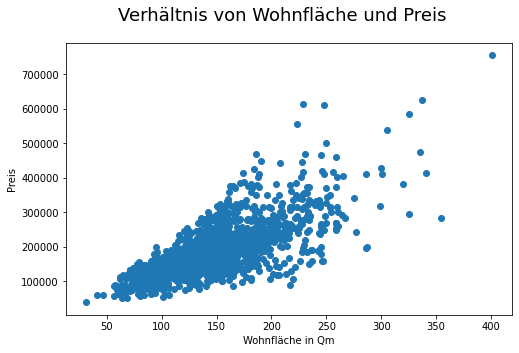

In [237]:
#Wohnfläche
plt.figure(figsize=(8,5))
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Preis"])

plt.suptitle("Verhältnis von Wohnfläche und Preis",fontsize=18)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis")
plt.show()
#Der Immobilienpreis und die Wohnfläche des Gebäudes sind voneinander abhängig.

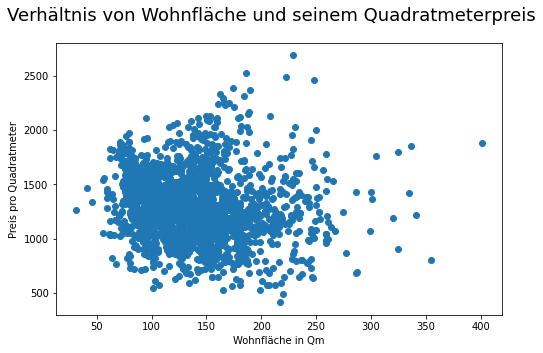

In [238]:
plt.figure(figsize=(8,5))
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Preis"]/housing_data["Wohnflaeche in qm"])

plt.suptitle("Verhältnis von Wohnfläche und seinem Quadratmeterpreis",fontsize=18)
plt.xlabel("Wohnfläche in Qm")
plt.ylabel("Preis pro Quadratmeter")
plt.show()
#Der Preis pro Quadratmeter ist nicht von der Wohnungsgröße abhängig